Vna_files
Prosesamiento de datos



In [ ]:
# !pip install git+https://github.com/dpk2442/pysmith.git#egg=pysmith

import numpy as np
import matplotlib.pyplot as plt
import cmath
from datetime import datetime
from scipy.optimize import fsolve

# import pysmith

In [ ]:
# https://pysmith.readthedocs.io/en/latest/

file_path = '/content/'
# file_path = '/content/rsc/'
file_name = [
# Mediciones del 15/11/23
            'Aire_15-11.s1p',#0
            'agua_15-11.s1p',#1
            'Acetona_15-11.s1p',#2
            'PLA_15-11.s1p',#3
            'ABS diluido_15-11.s1p',#4
            'alcohol_15-11.s1p',#5
            'dedo_15-11.s1p',#6
# Mediciones del 08/11/23
            'AIRE_8-11.s1p', #7
            'Agua_destilada_8-11.s1p',#8
            'resina_8-11.s1p',#9
            'Acetona_8-11.s1p',#10
            'azucar_8-11.s1p', #11
            'Alcohol_8-11.s1p', #12
              'Agua destilada N.s1p'
          ]
def vna_proc_file(file_path, file_name):
    file_path += file_name
    header_start  = '#'
    data_start    = '!'
    out_dict = {'Data' : [],
                     'Index': [],
                     'Frec' : [],
                    }

    frecuencies = np.array([])
    reals       = np.array([])
    imgs        = np.array([])

    try:
        file = open(file_path, "r")
    except:
        print('TODO: No se puede abrir')
        return 404

    file_list = file.readlines()
    # print(file_list)
    file.close()

    for line in file_list[12:]:
        values      = line.strip().split('\t')
        frecuencies = np.append(frecuencies, int(values[0]))
        reals       = np.append(reals, float(values[1]))
        imgs        = np.append(imgs, float(values[2]))

    out_dict['Data'   ] = file_list[0:11]
    out_dict['Index'  ] = file_list[11][1:].split(' ')
    out_dict['Frec'   ] = frecuencies
    out_dict['Img'    ] = imgs
    out_dict['Real'   ] = reals
    out_dict['Complex'] = reals +1j*imgs
    print('Archivo cargado: ',file_name)
    return out_dict

Conversión de parámetros

In [ ]:
def S11_to_Y11(frec, S11):
    z0 = 50
    y0 = 1/z0
    Y11 = y0*(( 1 - S11 ) / ( 1 + S11 ))
    return { 'Frec'    : frec,
             'Complex' : Y11,
            }

#Esta funcion calcula las curvas de Co y Go
#solo para el aire que E = 1
def calcular_C_G( Y, f):
  return {'Frec': f,
          'Co'  : Y.imag/(2*np.pi*f),
          'Go'  : Y.real,
          }
def ecuacion_trascendental(E, W, C, G, Y):
  return (1j * W * E * C + G*(E**2.5)) - Y # dan igual
#  return 1j * W * E * C + cmath.exp(2.5 * cmath.log(E**2)) * G - Y

def derivada_ecuacion_trascendental(E, W, C, G):
  return (1j*W*C + (5/2)*G*(E**2.5)/E) # dan igual
  # return 1j * W * C + 5 * cmath.exp(2.5 * cmath.log(E**2)) * G / (2 * E)

def Calculo_Ec(Y, f, C, G, E_inicial=(1 + 1j), tolerancia=(5e-2), max_iteraciones=10000):
    W = 2*np.pi*f
    E = E_inicial

    for _ in range(max_iteraciones):
        f = ecuacion_trascendental(E, W, C, G, Y)
        f_prime = derivada_ecuacion_trascendental(E, W, C, G)
        E -= f / f_prime
        if (abs(f) < tolerancia):
          # print('f:',f,'E:',E)
          return E

    print('dif: ',abs(f), 'E: ',E)
    raise RuntimeError("No se pudo converger a una solución en las iteraciones dadas.")

def Calculo_Ec_dic(Y11, CoGo):
  if np.array_equal(Y11['Frec'], CoGo['Frec']):

    Ec_dict = {'Frec': Y11['Frec'], 'Eo': []}
    Y_d     = Y11['Complex']
    frec_d  = Y11['Frec']
    Co_d    = CoGo['Co']
    Go_d    = CoGo['Go']
    #print(frec_d)
    # Iterar
    for Y_, frec_, Co_, Go_  in zip(Y_d, frec_d, Co_d, Go_d):
      #print('Y_=',Y_)
      #print('Frec_=',frec_)
      #print('Co_=',Co_)
      #print('Go_=',Go_)
      # Ec_dict['Frec'].append(frec_)

      if Ec_dict['Eo']:
        Ec_dict['Eo'].append(Calculo_Ec(Y_,frec_,Co_, Go_,Ec_dict['Eo'][-1]))
      else:
        Ec_dict['Eo'].append(Calculo_Ec(Y_,frec_,Co_, Go_))

    Ec_dict['Eo'] = np.asarray(Ec_dict['Eo'])
      #print('Eo = ',Ec_dict['Eo'][-1],' , F = ',Ec_dict['Frec'][-1])
    return  Ec_dict

  else:
    print('TODO: arrays diferente tamaño')
    return 404

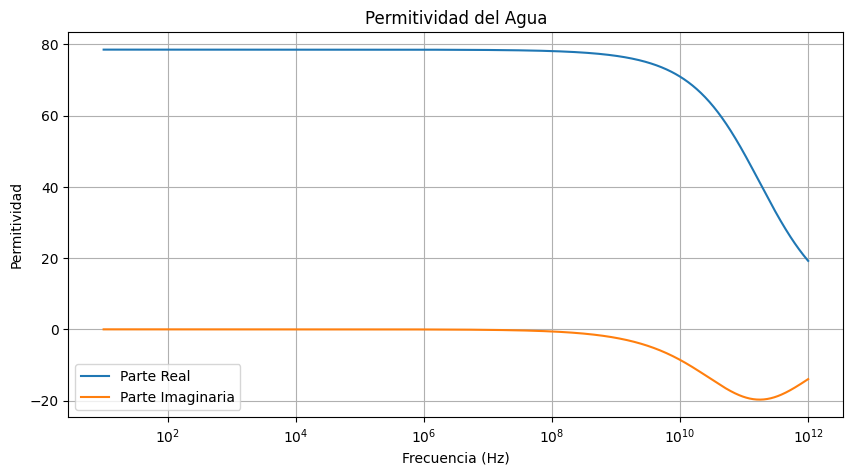

In [ ]:
# EC del agua

import numpy as np
import matplotlib.pyplot as plt

def permitividad_agua(frecuencias):
    # Parámetros típicos para el agua destilada a temperatura ambiente y frecuencias bajas
    epsilon_inf = 4.0  # Permitividad a frecuencias infinitas
    epsilon_0 = 78.5  # Permitividad a frecuencias cero
    tau = 9.11e-13     # Tiempo característico de relajación (s)
    alpha = 0.62       # Exponente

    # Frecuencia angular
    omega = 2 * np.pi * frecuencias

    # Modelo de Debye
    epsilon = epsilon_inf + (epsilon_0 - epsilon_inf) / (1 + (1j * omega * tau)**alpha)

    # Crear diccionario con los resultados
    resultados = {
        'Frec': frecuencias,
        'Complex': epsilon
    }

    return resultados

def graficar_permitividad(resultados):
    # Graficar la parte real e imaginaria de la permitividad
    plt.figure(figsize=(10, 5))
    plt.plot(resultados['Frec'], np.real(resultados['Complex']), label='Parte Real')
    plt.plot(resultados['Frec'], np.imag(resultados['Complex']), label='Parte Imaginaria')
    plt.xscale('log')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Permitividad')
    plt.legend()
    plt.title('Permitividad del Agua')
    plt.grid(True)
    plt.show()

# Frecuencias de interés (ajusta según tus necesidades)
frecuencias = np.logspace(1, 12, num=1000)

# Calcular la permitividad y graficar
Ec_Agua = permitividad_agua(frecuencias)
graficar_permitividad(Ec_Agua)

# Imprimir el diccionario con los resultados
#print(Ec_Agua)



In [ ]:
#Calculo del Ec del agua para una frec determinada


import numpy as np

def permitividad_agua_en_frecuencia(frecuencia):
    # Parámetros típicos para el agua destilada a temperatura ambiente y frecuencias bajas
    epsilon_inf = 4.0  # Permitividad a frecuencias infinitas
    epsilon_0 = 78.5  # Permitividad a frecuencias cero
    tau = 9.11e-13     # Tiempo característico de relajación (s)
    alpha = 0.62       # Exponente

    # Frecuencia angular
    omega = 2 * np.pi * frecuencia

    # Modelo de Debye
    epsilon = epsilon_inf + (epsilon_0 - epsilon_inf) / (1 + (1j * omega * tau)**alpha)

    return epsilon

# Frecuencia específica (ajusta según tus necesidades)
frecuencia_especifica = 1e9  # 1 GHz

# Calcular la permitividad para la frecuencia específica
resultado = permitividad_agua_en_frecuencia(frecuencia_especifica)

# Imprimir el resultado
print(f"Permitividad a {frecuencia_especifica} Hz: {resultado}")

Permitividad a 1000000000.0 Hz: (76.75426871119586-2.395255763191032j)


Archivo cargado:  Agua destilada N.s1p


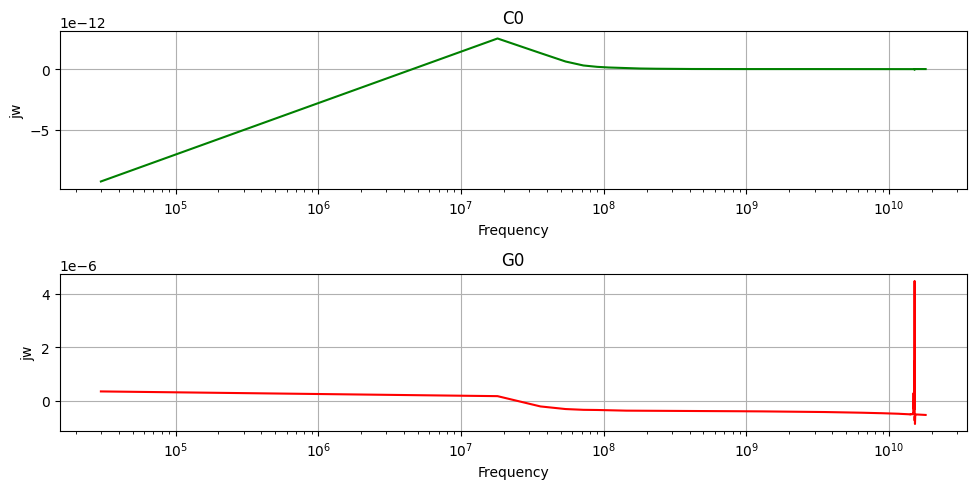

In [ ]:
# Nueva forma de calculo Go Y Co


# Y11 = j*W*Ec*Co + (Ec)^5/2 * Go

#Y11= a*C0 +B*Go
#Y11{img} = a{img}Co+b{img}Go
#Y11{real} = a{real}Co+b{real}Go

#Co = (Y11{img}-b{img}Go)/(a{img})
#Y11{real} = a{real}(#Y11{img}-b{img}Go)/(a{img})+b{real}Go
#Y11{real} = (a{real}*Y11{img})/a{img}+Go(-(a{real}*b{img})/a{img}+b{real})

# Go = (Y11{real} - (a{real}a{img})*#Y11{img}) / (-(a{real}a{img})b{img}+b{real})



def calcular_C_G_sin_simplificar( Y11_agua_dest_complex, frec_Y11_agua_dest):

  Ec = permitividad_agua_en_frecuencia(frec_Y11_agua_dest)
  W  = 2 * np.pi * frec_Y11_agua_dest
  Yr = np.real(Y11_agua_dest_complex)
  Yi = np.imag(Y11_agua_dest_complex)
  a  = 1j * W * Ec

  ar = np.real(a)
  ai = np.imag(a)
  b  = (Ec**2.5)
  br = np.real(b)
  bi = np.imag(b)

  Go = (Yr - (ar * Yi) / ai) / (br -(ar * bi)/ai)
  Co = (Yi - bi * Go)/ ai

#  print(f"frecuencia:{frec_Y11_agua_dest} Hz")
#  print(f"Ec:{Ec}")
#  print(f"Y11:{Y11_agua_dest_complex}")
#  print(f"Go:{Go}")
#  print(f"Co:{Co}")
#  Y =  1j* W * Ec * Co + (Ec**2.5) * Go
#  print(f"Y11:{Y}")
  return {'Frec': frec_Y11_agua_dest,
          'Co'  : Co,
          'Go'  : Go,
          }


dictionary = vna_proc_file(file_path, file_name[13])

Y11 = S11_to_Y11(dictionary['Frec'], dictionary['Complex'])

CoGo = calcular_C_G_sin_simplificar(Y11['Complex'],Y11['Frec'])




# print(CoGo)
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.xscale("log")
plt.plot(CoGo['Frec'], CoGo['Co'], color='g')
plt.title('C0')
plt.xlabel('Frequency')
plt.ylabel('jw')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.xscale("log")
plt.plot(CoGo['Frec'], CoGo['Go'], color='r')
plt.title('G0')
plt.xlabel('Frequency')
plt.ylabel('jw')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Y11 = j*W*Ec*Co + (Ec)^5/2 * Go

#Ec?

#Y11 = A * Ec + b* (Ec)^5/2

#RY * exp(tita Y) = WCo exp(90) * RE exp (tita E) + Go exp(0) * RE^5/2 exp(tita E * 5/2)
#RY * exp(tita Y) = WCoREexp(tita E + 90) + Go RE^5/2 exp(tita E * 5/2)





Archivo cargado:  Agua destilada N.s1p
[24054.21391152    81.40157372    78.16656622 ...    67.51149649
    67.50461848    67.49774341]


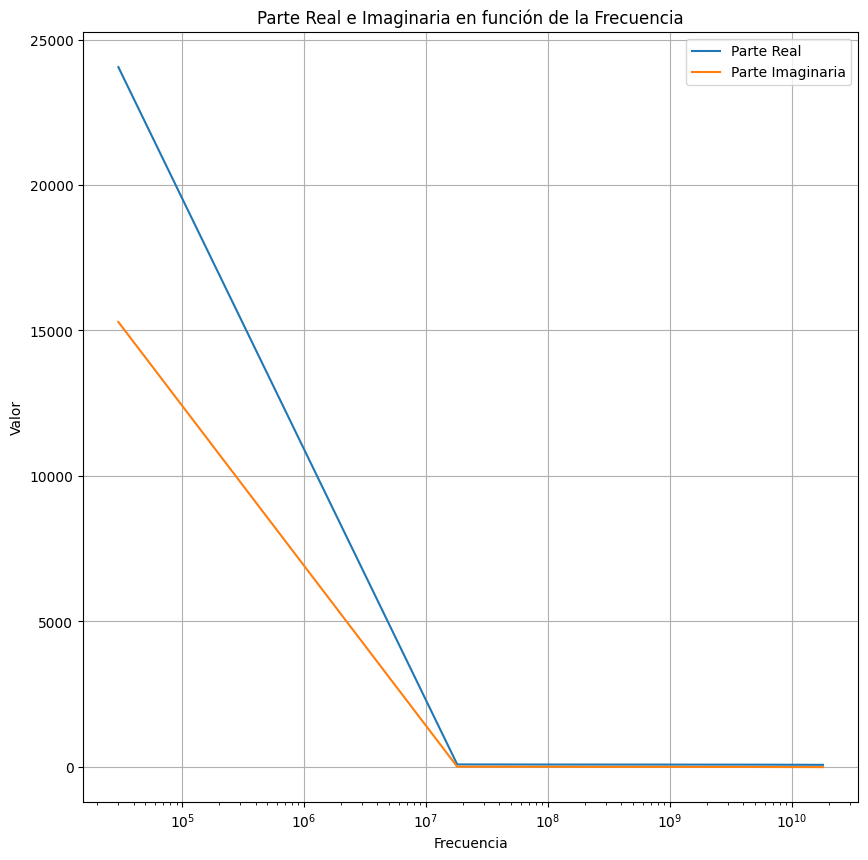

In [ ]:
#Chequeamos con el agua
dictionary_agua = vna_proc_file(file_path, file_name[13])
Y11_agua        = S11_to_Y11(dictionary_agua['Frec'], dictionary_agua['Complex'])
Ec              = Calculo_Ec_dic(Y11_agua, CoGo)
print(Ec['Eo'][:3000].real)
# Extraer frecuencias y números complejos

frecuencias  = Ec['Frec']
Ec_complejos = Ec['Eo']
# Extraer partes reales e imaginarias
partes_reales      = Ec_complejos.real
partes_imaginarias = Ec_complejos.imag
# Graficar
plt.figure(figsize=(10, 10))
plt.xscale("log")
plt.grid(True)
plt.plot(frecuencias, partes_reales, label='Parte Real')
plt.plot(frecuencias, partes_imaginarias, label='Parte Imaginaria')
# plt.ylim([-10, 10])
# plt.xlim(30000,4*1e9)
# Etiquetas y título
plt.xlabel('Frecuencia')
plt.ylabel('Valor')
plt.title('Parte Real e Imaginaria en función de la Frecuencia')
plt.legend()
plt.show()

In [ ]:
# Define the equation
def Yin_transm_line(Ec, Frecs, Y11, C0, G0):
    W  = 2*np.pi*Frecs
    return ((np.real(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.real) + np.imag(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.imag)

def system_equations(variables, *params):
    C0 = variables[0]
    G0 = variables[1]
    Ec, Frecs, Y11 = params

    W = 2 * np.pi * Frecs
    equation1 = np.real(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.real
    equation2 = np.imag(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.imag

    return np.concatenate([equation1, equation2])

# def solve_Yin_transm_line(Ec, Frecs, Y11, C0_guess, G0_guess):
#     params = (Ec, Frecs, Y11)
#     initial_guess = [C0_guess, G0_guess]  # Using the first values of the arrays
#     C0 = []
#     G0 = []
#     SOLUTION = fsolve(system_equations, initial_guess, args=params)

#     return SOLUTION


In [67]:
def system_equations_2(Ec, *params):
    Frecs, Y11, C0, G0 = params

    W = 2 * np.pi * Frecs
    equation1 = np.real(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.real
    equation2 = np.imag(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.imag

    return np.concatenate([equation1, equation2])

def solve_Yin_transm_line(Ec, Frecs, Y11, C0_guess, G0_guess):
    params = (Ec, Frecs, Y11)
    initial_guess = [C0_guess, G0_guess]  # Using the first values of the arrays
    C0 = []
    G0 = []
    SOLUTION = fsolve(system_equations, initial_guess, args=params)

    return SOLUTION

def solve_Ec_from_C0_G0(C0, G0, Y11, Frecs, Ec_guess):
    params = (Frecs, Y11, C0, G0)

    Ec_result = fsolve(system_equations_2, Ec_guess, args=params)

    return Ec_result


In [70]:
Ec_guess = Ec_Agua

In [76]:
 Y11_agua['Complex'][1]


<ipython-input-76-854ed65a2002>:1: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y11_agua['Complex'][1] is np.complex()


False

In [71]:
solve_Ec_from_C0_G0(CoGo['Co'],CoGo['Go'],Y11_agua['Complex'], Y11_agua['Frec'],Ec_guess)

TypeError: ignored

Lista de archivos

In [ ]:
for i, name in enumerate(file_name):
    print(f' "{i}": {name}')

 "0": Aire_15-11.s1p
 "1": agua_15-11.s1p
 "2": Acetona_15-11.s1p
 "3": PLA_15-11.s1p
 "4": ABS diluido_15-11.s1p
 "5": alcohol_15-11.s1p
 "6": dedo_15-11.s1p
 "7": AIRE_8-11.s1p
 "8": Agua_destilada_8-11.s1p
 "9": resina_8-11.s1p
 "10": Acetona_8-11.s1p
 "11": azucar_8-11.s1p
 "12": Alcohol_8-11.s1p
 "13": Agua destilada N.s1p


Para graficar y ver los parametros S de las señales

In [ ]:
dictionary = vna_proc_file(file_path, file_name[1])
print(dictionary)

Y11 = S11_to_Y11(dictionary['Frec'], dictionary['Complex'])

phase  = np.angle( dictionary['Complex'], deg=True)
module = np.abs(dictionary['Complex'] )

plt.figure(figsize=(10, 5))

# First subplot for the phase
plt.subplot(2, 1, 1)
# plt.xscale("log")
plt.plot(dictionary['Frec'], phase,  color='b')
plt.title('Phase Plot')
plt.xlabel('Frequency')
plt.ylabel('Phase (degrees)')
plt.grid(True)
plt.ylim(-200, 200)
# Second subplot for the absolute value (magnitude)
plt.subplot(2, 1, 2)
plt.xscale("log")
plt.plot(dictionary['Frec'], module, color='r')
plt.title('Magnitude Plot')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True)
# plt.ylim( -2, 2 )
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the figure with both subplots
plt.show()
pass

Para el agua Ec =1
=> Y11 = jCo + Go
=> R{Y11} = Go  y I{Y11] = WCo

In [ ]:
# Ejemplo de uso: de calculo EC
#Y = 2.45+0.0025j
#f = 1
#C = 2
#G = 1
E_inicial = 1 + 1j

Y= (0.00031085341347285674+0.0001745635512860292j)
f= 23429961.0
C= 1470.5490493345042
G= 0.00013315469747494452
#como E_inicial podemos pasarle el valor anterior
solucion = Calculo_Ec(Y, f, C, G, E_inicial)
# print("Solución encontrada para E:", solucion)
Y_ = 1j * 2*np.pi*f * solucion * C + cmath.exp(2.5 * cmath.log(solucion)) * G
# print("coincide?:", Y_)

# Nueva sección

In [ ]:
dictionary_aire = vna_proc_file(file_path, file_name[7])
Y11_aire = S11_to_Y11(dictionary_aire['Frec'], dictionary_aire['Complex'])
CoGo = calcular_C_G(Y11_aire['Complex'], Y11_aire['Frec']) #C0 y G0 del aire
# print(CoGo)
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.xscale("log")
plt.plot(dictionary_aire['Frec'], CoGo['Co'], color='g')
plt.title('C0')
plt.xlabel('Frequency')
plt.ylabel('jw')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.xscale("log")
plt.plot(dictionary_aire['Frec'], CoGo['Go'], color='r')
plt.title('G0')
plt.xlabel('Frequency')
plt.ylabel('jw')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
CoGo

Exportacion de archivo con todos los datos, de todas las mediciones (cargadas en los nombres de archivo de file_name)

In [ ]:
for mat_file in file_name:
  out_dict = vna_proc_file(file_path, mat_file)
  out_Y11  = S11_to_Y11(out_dict['Frec'], out_dict['Complex'])
  out_Ec   = Calculo_Ec_dic(out_Y11, CoGo)

  output_array = np.column_stack((np.real(out_Y11['Frec']), out_dict['Complex'], out_Y11['Complex'], CoGo['Co'], CoGo['Go'], out_Ec['Eo']))
  timestamp = datetime.now().strftime("%d%H%M%S")
  out_file_name = file_path + 'out/'+ mat_file[:(len(mat_file)-8)] + f"_{timestamp}.txt"
  np.savetxt(out_file_name, output_array, delimiter='\t', header='Frequency S11 Y11 Co  Go  Eo', comments=''+datetime.now().strftime("%d %m %Y %H:%M:%S") +'\t\n')


graficar y guardar Y11 en imag y real

In [ ]:
for mat_file in file_name:
  out_dict = vna_proc_file(file_path, mat_file)
  out_Y11  = S11_to_Y11(out_dict['Frec'], out_dict['Complex'])
  out_Ec   = Calculo_Ec_dic(out_Y11, CoGo)

  plt.figure(figsize=(10, 5))
  plt.subplot(2, 1, 1)
  plt.xscale("log")
  plt.plot(dictionary['Frec']*2*np.pi, np.real(out_Y11['Complex']),  color='b')
  plt.title('Real')
  plt.xlabel('Frequency')
  plt.ylabel('[S]')
  plt.grid(True)
  plt.subplot(2, 1, 2)
  plt.xscale("log")
  plt.plot(dictionary['Frec']*2*np.pi, np.imag(out_Y11['Complex']), color='r')
  plt.title('Imag')
  plt.xlabel('Frequency')
  plt.ylabel('jw')
  plt.grid(True)
  plt.tight_layout()
  timestamp = datetime.now().strftime("%d%H%M%S")
  out_file_name = file_path + 'out/'+ mat_file[:(len(mat_file)-8)] + f"_{timestamp}.png"
  # plt.savefig(out_file_name)

Graficar y grabar Ec y C0 G0 del aire

In [ ]:
for mat_file in file_name:
  out_dict = vna_proc_file(file_path, mat_file)
  out_Y11  = S11_to_Y11(out_dict['Frec'], out_dict['Complex'])
  out_Ec   = Calculo_Ec_dic(out_Y11, CoGo)

  plt.figure(figsize=(10, 5))
  plt.subplot(3, 1, 1)

  plt.plot(dictionary['Frec'], out_Ec['Eo'],  color='b')
  plt.title('Ec')
  plt.xlabel('Frequency')
  plt.grid(True)
  plt.subplot(3, 1, 2)
  plt.xscale("log")
  plt.plot(dictionary['Frec']*2*np.pi, CoGo['Co'], color='g')
  plt.title('C0')
  plt.xlabel('Frequency')
  plt.ylabel('jw')
  plt.grid(True)
  plt.subplot(3, 1, 3)
  plt.xscale("log")
  plt.plot(dictionary['Frec']*2*np.pi, CoGo['Go'], color='r')
  plt.title('G0')
  plt.xlabel('Frequency')
  plt.ylabel('jw')
  plt.grid(True)
  plt.tight_layout()
  timestamp = datetime.now().strftime("%d%H%M%S")
  out_file_name = file_path + 'out/'+ 'Ec_' + mat_file[:(len(mat_file)-8)] + f"_{timestamp}.png"
  # plt.savefig(out_file_name)

In [ ]:
from scipy.optimize import fsolve

dictionary_aire = vna_proc_file(file_path, file_name[0])
Y11_aire = S11_to_Y11(dictionary_aire['Frec'], dictionary_aire['Complex'])

CoGo = calcolar_C_G(Y11_aire['Complex'], Y11_aire['Frec']) #C0 y G0 del aire
print(CoGo)

# Define the equation
def equation(Ec, Frecs, Y11, C0, G0):
  W  = 2*np.pi*Frecs
  return ((np.real(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.real) + np.imag(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.imag)

# def equation(Ec, Frecs, Y11, C0, G0):
#   W = 2 * np.pi * Frecs
#   Ec_non_negative = np.maximum(Ec, 0)
#   real_part = np.real(1j * W * Ec_non_negative * C0 + Ec_non_negative**(5/2) * G0)
#   imag_part = np.imag(1j * W * Ec_non_negative * C0 + Ec_non_negative**(5/2) * G0)
#   return ((real_part - Y11.real) + (imag_part - Y11.imag))

# Initial guess for Ec
initial_guess = np.ones_like(Y11_aire['Complex'].real/Y11_aire['Complex'].real)
# Solve the equation using fsolve
result = fsolve(equation, initial_guess, args=( Y11_aire['Frec'],
                                                Y11_aire['Complex'],
                                                CoGo['Co'],
                                                CoGo['Go']))

plt.figure(figsize=(10, 10))
plt.xscale("log")
plt.grid(True)
# Graficar
plt.plot(Y11_aire['Frec'], result.real, label='Parte Real')
plt.plot(Y11_aire['Frec'], result.imag, label='Parte Imaginaria')

# Etiquetas y título
plt.xlabel('Frecuencia')
plt.ylabel('Valor')
plt.title('Parte Real e Imaginaria en función de la Frecuencia')

# Leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:

# # Create a 2D array with columns: frequency, real part, imaginary part

output_array = np.column_stack((Y11_aire['Frec'], np.real(result), np.imag(result)))

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f"output_{timestamp}.csv"
np.savetxt(file_name, output_array, delimiter=',', header='Frequency,Real,Imaginary', comments='')

# Load the data back from the CSV file
loaded_data = np.loadtxt(file_name, delimiter=',', skiprows=1)  # Skip the header row

print("Loaded Data:")
print(loaded_data)

In [ ]:
def S11_to_Y11(frec, S11):
    z0 = 50
    y0 = 1/z0
    Y11 = y0*(( 1 - S11 ) / ( 1 + S11 ))
    return { 'Frec'    : frec,
             'Complex' : Y11,
            }

def get_debye_model(frecs):
    w     = frecs*2*np.pi
    E_inf = 4.6
    E_s   = 78.3
    tau   = 8.07e-12
    # print(tau)
    E_c   = E_inf + (E_s-E_inf)/(1+1j*w*tau)
    # print(E_c)
    return E_c

# Define the equation
def Yin_transm_line(Ec, Frecs, Y11, C0, G0):
    W  = 2*np.pi*Frecs
    return ((np.real(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.real) + np.imag(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.imag)

def system_equations(variables, *params):
    C0 = variables[0]
    G0 = variables[1]
    Ec, Frecs, Y11 = params

    W = 2 * np.pi * Frecs
    equation1 = np.real(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.real
    equation2 = np.imag(1j * W * Ec * C0 + Ec**(5/2) * G0) - Y11.imag

    return np.concatenate([equation1, equation2])

def solve_Yin_transm_line(Ec, Frecs, Y11, C0_guess, G0_guess):
    params = (Ec, Frecs, Y11)
    initial_guess = [C0_guess, G0_guess]  # Using the first values of the arrays
    C0 = []
    G0 = []
    SOLUTION = fsolve(system_equations, initial_guess, args=params)

    return SOLUTION


In [ ]:
dictionary_aire = vna_proc_file(file_path, file_name[7])
# dictionary_aire = vna_proc_file(file_path, file_name[0])
Y11_aire = S11_to_Y11(dictionary_aire['Frec'], dictionary_aire['Complex'])

dictionary_agua = vna_proc_file(file_path, file_name[1])
Ec_agua_dest    = get_debye_model(dictionary_agua['Frec'])
Y11_agua        = S11_to_Y11(dictionary_agua['Frec'], dictionary_agua['Complex'])

C0_guess = np.ones(len(Y11_agua['Frec'])) * 1e-12
G0_guess = np.ones(len(Y11_agua['Frec'])) * 1e-6


SOLUTION = solve_Yin_transm_line(Ec_agua_dest, Y11_agua['Frec'], Y11_agua['Complex'], C0_guess, G0_guess)


In [ ]:
len(dictionary_agua['Frec'])

201

In [ ]:
# print(Ec_agua_dest)
len(Ec_agua_dest)

201

In [ ]:
# print(SOLUTION)
len(SOLUTION)

402

In [ ]:
C0 = SOLUTION[:(int)(len(SOLUTION)/2)]
G0 = SOLUTION[(int)(len(SOLUTION)/2):]

In [ ]:
len(Y11_agua['Frec'])

In [ ]:

# # Create a 2D array with columns: frequency, real part, imaginary part

output_array = np.column_stack((Y11_agua['Frec'], dictionary_agua['Complex'], Y11_agua['Complex'],Ec_agua_dest, C0, G0))

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f"AGUA_DEST_PROC_{timestamp}.csv"
np.savetxt(file_name, output_array, delimiter=',', header='S11, Y11, EC, C0, G0', comments='')


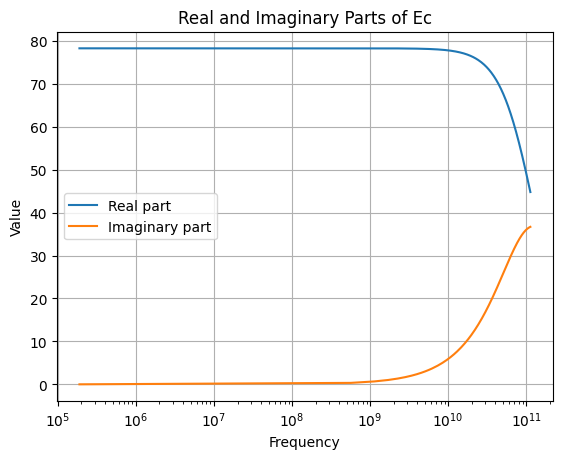

In [ ]:
frequency    = Y11_agua['Frec']
complex_data = Ec_agua_dest

# Plot real part
plt.plot(frequency * 2 * np.pi, np.real(complex_data), label='Real part')

# Plot imaginary part
plt.plot(frequency * 2 * np.pi,- np.imag(complex_data), label='Imaginary part')

# Set labels and title
plt.title('Real and Imaginary Parts of Ec')
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.xscale('log')
# Add a legend to distinguish real and imaginary parts
plt.legend()

# Display the plot
plt.grid(True)
plt.show()